In [1]:
# !pip install tf-nightly==2.8.0.dev20210925
# !pip install tensorflow-federated-nightly==0.19.0.dev20210619
# !pip install --quiet --upgrade nest-asyncio




In [2]:
import nest_asyncio
nest_asyncio.apply()
%cd /content/drive/MyDrive/federated


/content/drive/MyDrive/federated


In [3]:
%load_ext tensorboard

In [ ]:
import collections
import time

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

In [5]:
# gpu_devices = tf.config.list_physical_devices('GPU')
# if not gpu_devices:
#   raise ValueError('Cannot detect physical GPU device in TF')
# tf.config.set_logical_device_configuration(
#     gpu_devices[0], 
#     [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
#      tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
# tf.config.list_logical_devices()


In [6]:
@tff.federated_computation
def hello_world():
  return 'Hello, World!'

hello_world()


b'Hello, World!'

In [7]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(only_digits=True)


In [8]:
def preprocess_fn(dataset, batch_size=16):

  def batch_format_fn(element):
    return (tf.expand_dims(element['pixels'], -1), element['label'])

  return dataset.batch(batch_size).map(batch_format_fn)

train_data1 = emnist_train.preprocess(preprocess_fn)

def preprocess_emnist_dataset(client_epochs_per_round, batch_size, test_batch_size):

  def element_fn(element):
    return collections.OrderedDict(
        x=tf.expand_dims(element['pixels'], -1), y=element['label'])

  def preprocess_train_dataset(dataset):
    # Use buffer_size same as the maximum client dataset size,
    # 418 for Federated EMNIST
    return dataset.map(element_fn).shuffle(buffer_size=418).repeat(
        count=client_epochs_per_round).batch(batch_size, drop_remainder=False)

  def preprocess_test_dataset(dataset):
    return dataset.map(element_fn).batch(test_batch_size, drop_remainder=False)

  train_set = emnist_train.preprocess(preprocess_train_dataset)
  test_set = preprocess_test_dataset(
      emnist_test.create_tf_dataset_from_all_clients())
  return train_set, test_set

In [9]:
def _conv_3x3(input_tensor, filters, strides):
  
  x = tf.keras.layers.Conv2D(
      filters=filters,
      strides=strides,
      kernel_size=3,
      padding='same',
      kernel_initializer='he_normal',
      use_bias=False,
  )(input_tensor)
  return x


def _basic_block(input_tensor, filters, strides):
  
  x = input_tensor
  x = _conv_3x3(x, filters, strides)
  x = tf.keras.layers.Activation('relu')(x)

  x = _conv_3x3(x, filters, 1)
  x = tf.keras.layers.Activation('relu')(x)
  return x





def create_cnn(conv_width_multiplier=1, num_classes=10):
  
  input_shape = (28, 28, 1)  # channels_last
  img_input = tf.keras.layers.Input(shape=input_shape)
  x = img_input
  x = tf.image.per_image_standardization(x)
  x = _basic_block(x,32,1)
  x = _basic_block(x,64,1)
  
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(512,activation='relu')(x)
  x = tf.keras.layers.Dense(num_classes)(x)

  model = tf.keras.models.Model(
      img_input,
      x,
      name='cnn1')
  return model

def create_cnn1(conv_width_multiplier=1, num_classes=10):
  
  input_shape = (28, 28, 1)  # channels_last
  img_input = tf.keras.layers.Input(shape=input_shape)
  x = img_input
  x = tf.image.per_image_standardization(x)
  x = _basic_block(x,32,1)
  x = _basic_block(x,64,1)
  
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(512,activation='relu')(x)
  x = tf.keras.layers.Dense(num_classes,activation='softmax')(x)

  model = tf.keras.models.Model(
      img_input,
      x,
      name='cnn1')
  return model

In [10]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

import pandas as pd
import numpy as np

dict1={'img':list(x_train),'label':y_train}
df=pd.DataFrame(dict1)

dfs=pd.DataFrame()

dig=list(range(0,10))
for i in dig:
  df1=df[df.label==i][:60]
  dfs=pd.concat([dfs,df1])

print(dfs.label.value_counts())

aux_x=dfs['img'].values
aux_x=np.stack(aux_x)
aux_x=np.reshape(aux_x,(aux_x.shape[0],28,28,1))
print(aux_x.shape)
aux_y=np.array(dfs['label'])
aux_y=to_categorical(aux_y)
print(aux_y.shape)

def model_fn1():
  keras_model = create_cnn1()
  keras_model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
  return keras_model

model1=model_fn1()


model1.fit(aux_x,aux_y,epochs=3)

model1.save_weights('aux.h5')

model1.load_weights('aux.h5')


11501568/11490434 [==============================] - 0s 0us/step
0    60
1    60
2    60
3    60
4    60
5    60
6    60
7    60
8    60
9    60
Name: label, dtype: int64
(600, 28, 28, 1)
(600, 10)
Epoch 1/3
19/19 [==============================] - 6s 290ms/step - loss: 2.3216 - accuracy: 0.0833
Epoch 2/3
19/19 [==============================] - 5s 282ms/step - loss: 2.3083 - accuracy: 0.1000
Epoch 3/3
19/19 [==============================] - 5s 281ms/step - loss: 2.3049 - accuracy: 0.0983


In [11]:
from numpy import linalg as LA
def weight_convergence(model1,model2):
  wl1=[]
  wd1=0
  for layer in model1.layers:
    l=layer.get_weights()
    wl1.append(l)
  for i in range(len(wl1)):
    for j in range(len(wl1[i])):
      d=LA.norm(wl1[i][j])
      s=d.sum()
      wd1+=s  
    

  wl2=[]
  for layer in model2.layers:
    l=layer.get_weights()
    wl2.append(l)  
  wd=0  
  for i in range(len(wl1)):
    for j in range(len(wl1[i])):
      d=LA.norm(wl1[i][j]-wl2[i][j])
      s=d.sum()
      wd+=s
  print(wd/wd1)
  return wd/wd1




import tensorflow_datasets as tfds

def dataset_to_numpy(ds):
    """
    Convert tensorflow dataset to numpy arrays
    """
    images = []
    labels = []

    # Iterate over a dataset
    for i, (image, label) in enumerate(tfds.as_numpy(ds)):
        #images.append(image)
        for i in image:
          images.append(i)
        for i in label:
          labels.append(i)  

    return images, labels



def select_random(Nt1,c):
  from random import sample
  Nt=sample(Nt1,c)
  return Nt


def client_selection(cl,train_data,n1):
  candidates=select_random(cl,100)
  print(candidates)
  sampled_train_data1 = [train_data.create_tf_dataset_for_client(client) for client in candidates]
  dict1={}
  for i in range(len(candidates)):
    try:
      model2=model_fn1() 
      x,y=dataset_to_numpy(sampled_train_data1[i])
      x=np.array(x)
      y=np.array(y)
      #print(y)
      y=to_categorical(y,num_classes=10)
    
      model2.fit(x,y,epochs=1)
      c=weight_convergence(model1,model2)
      dict1[candidates[i]]=c
    except Exception as e:
      print(e)
      continue  
  dict2={k: v for k, v in sorted(dict1.items(), key=lambda item: item[1])}
  #num_clients1=int(NUM_CLIENTS*alpha)
  c1=list(dict2.keys())
  c2=c1[:n1]
  print('clients selected')
  return c2


In [12]:
import logging
def keras_evaluate(model, test_data, metric):
  metric.reset_states()
  for batch in test_data:
    preds = model(batch['x'], training=False)
    metric.update_state(y_true=batch['y'], y_pred=preds)
  return metric.result()


def run_federated_training(client_epochs_per_round, 
                           train_batch_size, 
                           test_batch_size, 
                           cnn_num_blocks, 
                           conv_width_multiplier,
                           server_learning_rate, 
                           client_learning_rate, 
                           total_rounds, 
                           clients_per_round, 
                           rounds_per_eval,
                           logdir='logdir'):

  train_data, test_data = preprocess_emnist_dataset(
      client_epochs_per_round, train_batch_size, test_batch_size)
  data_spec = test_data.element_spec

  print(train_data.client_ids)
  print(train_data1.client_ids)
  # return

  def _model_fn():
    keras_model = create_cnn()
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    return tff.learning.from_keras_model(
        keras_model, input_spec=data_spec, loss=loss)

  def _server_optimizer_fn():
    return tf.keras.optimizers.SGD(learning_rate=server_learning_rate)

  def _client_optimizer_fn():
    return tf.keras.optimizers.SGD(learning_rate=client_learning_rate)

  iterative_process = tff.learning.build_federated_averaging_process(
      model_fn=_model_fn, 
      server_optimizer_fn=_server_optimizer_fn, 
      client_optimizer_fn=_client_optimizer_fn, 
      use_experimental_simulation_loop=True)

  metric = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
  eval_model = create_cnn()
  logging.info(eval_model.summary())

  server_state = iterative_process.initialize()
  start_time = time.time()
  acc=[]
  loss=[]
  for round_num in range(total_rounds):
    sampled_clients = client_selection(train_data.client_ids,train_data1,clients_per_round)
    print(sampled_clients)
    sampled_train_data = [
        train_data.create_tf_dataset_for_client(client)
        for client in sampled_clients
    ]
    if round_num == total_rounds-1:
      with tf.profiler.experimental.Profile(logdir):
        server_state, train_metrics = iterative_process.next(
            server_state, sampled_train_data)
    else:
      server_state, train_metrics = iterative_process.next(
            server_state, sampled_train_data)
    print(f'Round {round_num} training loss: {train_metrics["train"]["loss"]}, 'f'time: {(time.time()-start_time)/(round_num+1.)} secs')
    if round_num % rounds_per_eval == 0 or round_num == total_rounds-1:
      server_state.model.assign_weights_to(eval_model)
      accuracy = keras_evaluate(eval_model, test_data, metric)
      acc.append(accuracy)
      loss.append(train_metrics["train"]["loss"])
      print(f'Round {round_num} validation accuracy: {accuracy * 100.0}')
  return acc,loss    
    


In [14]:

# cpu_device = tf.config.list_logical_devices('CPU')[0]
# tff.backends.native.set_local_python_execution_context(
#     server_tf_device=cpu_device, client_tf_devices=[cpu_device])

rounds=35

acc,loss=run_federated_training(
    client_epochs_per_round=1, 
    train_batch_size=16, 
    test_batch_size=128, 
    cnn_num_blocks=2, 
    conv_width_multiplier=4,
    server_learning_rate=1.0, 
    client_learning_rate=0.05,
    total_rounds=rounds,
    clients_per_round=5, 
    rounds_per_eval=1,
    )



['f0000_14', 'f0001_41', 'f0005_26', 'f0006_12', 'f0008_45', 'f0011_13', 'f0014_19', 'f0016_39', 'f0017_07', 'f0022_10', 'f0023_08', 'f0029_05', 'f0030_12', 'f0031_02', 'f0032_27', 'f0034_08', 'f0035_19', 'f0036_39', 'f0037_16', 'f0038_42', 'f0039_14', 'f0040_25', 'f0041_30', 'f0042_43', 'f0043_10', 'f0048_00', 'f0049_32', 'f0052_42', 'f0054_14', 'f0055_09', 'f0058_07', 'f0059_21', 'f0062_25', 'f0064_04', 'f0065_00', 'f0066_37', 'f0067_25', 'f0068_00', 'f0069_14', 'f0071_21', 'f0072_36', 'f0075_46', 'f0077_13', 'f0081_26', 'f0082_40', 'f0083_09', 'f0084_19', 'f0085_01', 'f0087_24', 'f0088_22', 'f0089_16', 'f0090_10', 'f0093_24', 'f0094_41', 'f0096_45', 'f0097_05', 'f0098_33', 'f0102_31', 'f0104_43', 'f0106_05', 'f0107_06', 'f0108_12', 'f0110_48', 'f0112_07', 'f0113_31', 'f0115_34', 'f0116_23', 'f0119_44', 'f0120_29', 'f0122_45', 'f0123_28', 'f0124_11', 'f0125_02', 'f0127_07', 'f0128_00', 'f0129_32', 'f0130_28', 'f0133_23', 'f0135_03', 'f0139_23', 'f0141_43', 'f0142_39', 'f0144_05', 'f0

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


['f3838_46', 'f2071_28', 'f1045_35', 'f3961_03', 'f3736_09', 'f0784_30', 'f0423_04', 'f1691_07', 'f1778_11', 'f4069_03', 'f1286_47', 'f3161_02', 'f1819_37', 'f0680_28', 'f3652_48', 'f1439_27', 'f3448_15', 'f2249_75', 'f3822_47', 'f2577_65', 'f3279_28', 'f3921_41', 'f1121_47', 'f0783_27', 'f3749_27', 'f1300_41', 'f3210_22', 'f3517_27', 'f1505_21', 'f1143_43', 'f2467_77', 'f0366_08', 'f1513_07', 'f0035_19', 'f3120_04', 'f1063_36', 'f1653_02', 'f1397_09', 'f0872_30', 'f1566_38', 'f3592_19', 'f1396_07', 'f3603_14', 'f0574_03', 'f1381_00', 'f2274_95', 'f1641_09', 'f1628_45', 'f3626_35', 'f1796_21', 'f3676_37', 'f1499_12', 'f3340_15', 'f1436_39', 'f1065_10', 'f1070_09', 'f1791_04', 'f1066_29', 'f0968_30', 'f2554_55', 'f0694_49', 'f3949_09', 'f3747_12', 'f1824_18', 'f0710_08', 'f2020_16', 'f2427_89', 'f1029_30', 'f0956_32', 'f0358_32', 'f3971_41', 'f1437_23', 'f2360_75', 'f0847_06', 'f0403_29', 'f2593_72', 'f0860_21', 'f3275_40', 'f1463_23', 'f0062_25', 'f3424_24', 'f0658_30', 'f0521_14', 'f1

4/4 [==============================] - 1s 220ms/step - loss: 2.3200 - accuracy: 0.1154
1.4156673220247609
4/4 [==============================] - 1s 222ms/step - loss: 2.3245 - accuracy: 0.0952
1.4128996478060207
4/4 [==============================] - 1s 217ms/step - loss: 2.3315 - accuracy: 0.0980
1.4081796707826344
4/4 [==============================] - 1s 230ms/step - loss: 2.3224 - accuracy: 0.0935
1.4109391861023384
4/4 [==============================] - 1s 222ms/step - loss: 2.3157 - accuracy: 0.1058
1.4222535345588774
4/4 [==============================] - 2s 238ms/step - loss: 2.3139 - accuracy: 0.0364
1.41925015723378
3/3 [==============================] - 1s 261ms/step - loss: 2.3191 - accuracy: 0.1011
1.4194355464849127
4/4 [==============================] - 1s 237ms/step - loss: 2.3113 - accuracy: 0.1081
1.4171723801528215
3/3 [==============================] - 1s 255ms/step - loss: 2.3327 - accuracy: 0.0795
1.4062201020120426
4/4 [==============================] - 1s 228ms/

Streaming output truncated to the last 5000 lines.
3/3 [==============================] - 1s 238ms/step - loss: 2.3380 - accuracy: 0.0385
1.4183923803540226
4/4 [==============================] - 2s 252ms/step - loss: 2.3174 - accuracy: 0.0971
1.417434002815594
3/3 [==============================] - 1s 298ms/step - loss: 2.3275 - accuracy: 0.0909
1.420730796997825
3/3 [==============================] - 1s 288ms/step - loss: 2.3272 - accuracy: 0.0909
1.4045337059602574
4/4 [==============================] - 2s 291ms/step - loss: 2.3112 - accuracy: 0.1043
1.3982042475112442
4/4 [==============================] - 2s 267ms/step - loss: 2.3357 - accuracy: 0.0826
1.4112441038147612
3/3 [==============================] - 1s 209ms/step - loss: 2.3431 - accuracy: 0.0870
1.404499364254928
4/4 [==============================] - 2s 275ms/step - loss: 2.3214 - accuracy: 0.0973
1.4083831692223148
4/4 [==============================] - 2s 277ms/step - loss: 2.3115 - accuracy: 0.0885
1.410815223341950

[<tf.Tensor: shape=(), dtype=float32, numpy=0.09580721>, <tf.Tensor: shape=(), dtype=float32, numpy=0.098770574>, <tf.Tensor: shape=(), dtype=float32, numpy=0.105481>, <tf.Tensor: shape=(), dtype=float32, numpy=0.10550549>, <tf.Tensor: shape=(), dtype=float32, numpy=0.098770574>, <tf.Tensor: shape=(), dtype=float32, numpy=0.10966889>, <tf.Tensor: shape=(), dtype=float32, numpy=0.20927215>, <tf.Tensor: shape=(), dtype=float32, numpy=0.10072982>, <tf.Tensor: shape=(), dtype=float32, numpy=0.10072982>, <tf.Tensor: shape=(), dtype=float32, numpy=0.2190194>, <tf.Tensor: shape=(), dtype=float32, numpy=0.2234522>, <tf.Tensor: shape=(), dtype=float32, numpy=0.17496082>, <tf.Tensor: shape=(), dtype=float32, numpy=0.21294573>, <tf.Tensor: shape=(), dtype=float32, numpy=0.19714929>, <tf.Tensor: shape=(), dtype=float32, numpy=0.29058093>, <tf.Tensor: shape=(), dtype=float32, numpy=0.24620396>, <tf.Tensor: shape=(), dtype=float32, numpy=0.14510678>, <tf.Tensor: shape=(), dtype=float32, numpy=0.2575

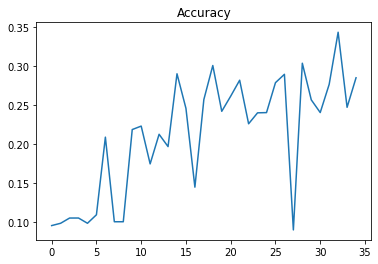

In [15]:
import numpy as np
import matplotlib.pyplot as plt
x1=np.array(range(rounds))
y1=np.array(acc)
print(acc)
plt.title("Accuracy")
plt.plot(x1, y1)  # Plot the chart
plt.show()

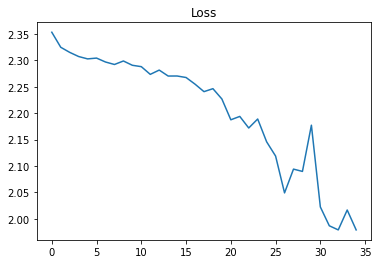

In [16]:
import numpy as np
x1=np.array(range(rounds))
y1=np.array(loss)
plt.title("Loss")
plt.plot(x1, y1)  # Plot the chart
plt.show()